In [1]:
import cv2
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils import detection
from photutils.aperture import CircularAperture, aperture_photometry
import glob

def detect_star(image_data):
    # Smooth the image to enhance star-like features
    smoothed_image = cv2.GaussianBlur(image_data, (5, 5), 0)

    # Find local peaks (potential stars) in the image
    peaks = detection.find_peaks(smoothed_image, threshold=3*np.std(smoothed_image), box_size=11)

    # Get the x and y coordinates of the peaks
    x_peak = peaks['x_peak']
    y_peak = peaks['y_peak']

    return x_peak, y_peak

def calculate_apparent_magnitude(image_file):
    # Load the image
    image_data = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Detect stars and their positions
    star_positions = detect_star(image_data)

    if len(star_positions[0]) == 0 or len(star_positions[1]) == 0:
        print("No stars were detected in the image.")
        return

    # Calculate background statistics
    mean, median, std = sigma_clipped_stats(image_data)

    # Calculate the center of the image
    image_center = np.array(image_data.shape[::-1]) / 2

    # Calculate distances of each detected star from the center
    distances_from_center = np.sqrt((star_positions[0] - image_center[0])**2 + (star_positions[1] - image_center[1])**2)

    # Find the index of the star closest to the center
    closest_star_index = np.argmin(distances_from_center)

    # Get the coordinates of the closest star
    closest_star_x = star_positions[0][closest_star_index]
    closest_star_y = star_positions[1][closest_star_index]

    print("Closest star at position {}, {}".format(closest_star_x, closest_star_y))

    # Perform photometry for the closest star
    # Define the aperture radius based on the star's size (e.g., FWHM)
    # Estimate the size of the star
    star_size_estimate = 100  # Example initial estimate for star size
    aperture_radius = star_size_estimate / 2.0  # Using half of the estimated size as the aperture radius

    # Define the aperture
    position = (closest_star_x, closest_star_y)
    aperture = CircularAperture(position, r=aperture_radius)

    # Perform aperture photometry
    phot_table = aperture_photometry(image_data - median, aperture)

    # Get the total flux in the aperture
    flux = phot_table['aperture_sum'][0]

    # Perform zero-point calibration (replace this with your own calibration)
    zero_point_calibration = 25.0  # Example value
    magnitude = -2.5 * np.log10(flux)

    # print("Closest star apparent magnitude:", magnitude)
    # print("Closest star flux:", flux)
    return flux

# Example usage
if __name__ == "__main__":
    # Example JPG image file
    image_file = "/Users/jminding/Documents/Research/Star Images/Alnitak.jpg"
    image_file_2 = "/Users/jminding/Documents/Research/Star Images/Vega.jpg"

    # print("Calculating apparent magnitude for image file:", image_file)
    # print(np.log10(calculate_apparent_magnitude(image_file)))
    print(-2.5 * np.log10(calculate_apparent_magnitude(image_file) / calculate_apparent_magnitude(image_file_2)))

Closest star at position 250, 250
Closest star at position 250, 250
0.09470562637471847


In [12]:
absolute_magnitudes = {
    'O': {
        'I': (-9.5, -8.0),
        'II': (-1.0, 2.0),
        'III': (-1.0, 2.0),
        'IV': (2.0, 4.0),
        'V': (-9.0, -4.0)
    },
    'B': {
        'I': (-9.0, -7.0),
        'II': (-1.0, 2.0),
        'III': (-1.0, 2.0),
        'IV': (2.0, 4.0),
        'V': (-3.0, 2.0)
    },
    'A': {
        'I': (-8.5, -6.5),
        'II': (-1.0, 2.0),
        'III': (-1.0, 2.0),
        'IV': (2.0, 4.0),
        'V': (2.0, 5.0)
    },
    'F': {
        'I': (-9.0, -5.0),
        'II': (-1.0, 2.0),
        'III': (-1.0, 2.0),
        'IV': (2.0, 4.0),
        'V': (4.0, 6.0)
    },
    'G': {
        'I': (-10.0, -4.0),
        'II': (-1.0, 2.0),
        'III': (-1.0, 2.0),
        'IV': (2.0, 4.0),
        'V': (5.0, 7.0)
    },
    'K': {
        'I': (-9.5, -3.0),
        'II': (-1.0, 2.0),
        'III': (-1.0, 2.0),
        'IV': (2.0, 4.0),
        'V': (6.0, 10.0)
    },
    'M': {
        'I': (-6.5, -4.0),
        'II': (-1.0, 2.0),
        'III': (-1.0, 2.0),
        'IV': (2.0, 4.0),
        'V': (10.0, 15.0)
    }
}
condensed_absolute_magnitudes = {}

for spectral_type, luminosity_classes in absolute_magnitudes.items():
    condensed_absolute_magnitudes[spectral_type] = {}
    for luminosity_class, magnitude_range in luminosity_classes.items():
        condensed_absolute_magnitudes[spectral_type][luminosity_class] = sum(magnitude_range) / 2

# print(condensed_absolute_magnitudes)


In [13]:
from mk_ai.MKAI import MKAI

image_file = "/Users/jminding/Documents/Research/Star Images/Alnitak.jpg"
image_file_2 = "/Users/jminding/Documents/Research/Star Images/Vega.jpg"
print("Calculating apparent magnitude for image file:", image_file)
apparent_magnitude = calculate_apparent_magnitude(image_file)
print("Apparent magnitude:", apparent_magnitude)

test = MKAI()
spectral_class, _ = test.get_spectral_class(image_file)
luminosity_class, _ = test.get_luminosity_class(image_file)
absolute_magnitude = condensed_absolute_magnitudes[spectral_class][luminosity_class]
print("Absolute magnitude:", absolute_magnitude)

Calculating apparent magnitude for image file: /Users/jminding/Documents/Research/Star Images/Alnitak.jpg
Closest star at position 250, 250
Apparent magnitude: 1.0324189526184537
Absolute magnitude: -8.75


In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

distances = np.load('distances.npy').tolist()

# for file in sorted(os.listdir('/Users/jminding/Documents/Research/Star Images')):
#     if file.endswith('.jpg'):
#         print("Calculating apparent magnitude for image file:", file)
#         apparent_magnitude = calculate_apparent_magnitude('/Users/jminding/Documents/Research/Star Images/' + file)
#         print("Apparent magnitude:", apparent_magnitude)

#         test = MKAI()
#         spectral_class, _ = test.get_spectral_class('/Users/jminding/Documents/Research/Star Images/' + file)
#         luminosity_class, _ = test.get_luminosity_class('/Users/jminding/Documents/Research/Star Images/' + file)
#         absolute_magnitude = condensed_absolute_magnitudes[spectral_class][luminosity_class]
#         print("Absolute magnitude:", absolute_magnitude)

#         distances.append(10 ** ((apparent_magnitude - absolute_magnitude + 5) / 5))

# distances_npy = np.array(distances)
# np.save('distances.npy', distances_npy)
# np.savetxt('distances.txt', distances_npy)

# df = pd.read_csv('/Users/jminding/Documents/Research/star_data_2.csv')
# distances_real = df['Distance (pc)']
# plt.scatter(distances_real, distances)

In [24]:
df = pd.read_csv('/Users/jminding/Documents/Research/star_data_3.csv')
distances_real = df['Distance (pc)']
# print(distances_npy.shape)
# plt.scatter(distances_real, distances)

In [25]:
stars = sorted(os.listdir('/Users/jminding/Documents/Research/Star Images'))
stars = [star.replace(".jpg", "").replace(".jpeg", "") for star in stars]

# Find stars that aren't in the star_data_3.csv file and find their indices
for star in stars:
    if star not in df['Star Name'].to_list():
        distances[stars.index(star)] = 0

print(distances)

[0, 19.03492290563518, 1.7554522770802072, 4.379217430965822, 3.8846883843702122, 0, 13.944053083958416, 13.379316121656496, 13.720062774212138, 13.465137436134144, 4.317124071914733, 0.8340757883352793, 13.690174301709707, 21.897725255291355, 13.471825038475238, 1.7433978606803584, 3.4651364323268012, 12.37517771311764, 13.502803267762705, 4.399380456489829, 21.783366230815744, 21.997280810892512, 4.336879859896369, 13.97555725399699, 13.809097812039044, 3.5090666949709077, 13.816530577235497, 22.049133206620233, 4.409496755960368, 4.319281123375031, 13.848301450963177, 13.753207329465218, 21.647685574828284, 4.491269101736349, 3.5264107531973474, 13.848301450963177, 13.682265951812056, 552.5785404607379, 308.6039611640403, 21.636371044583214, 12.29996498378928, 675.1906722944028, 904.6566719751067, 12.866970617636019, 13.095327496982144, 4.329213235810784, 4.33891825129686, 13.880145381266955, 1.7388016217477238, 0.4357994691292708, 3.427931018295586, 0.43093717972637363, 13.81210874

In [26]:
while 0 in distances:
    distances.remove(0)
print(len(distances))

429


In [27]:
distances.append(1)
distances.append(1)

In [28]:
print(distances_real.shape)
print(len(distances))

(431,)
431


Text(0.5, 1.0, 'Real vs. Calculated Distances of Stars')

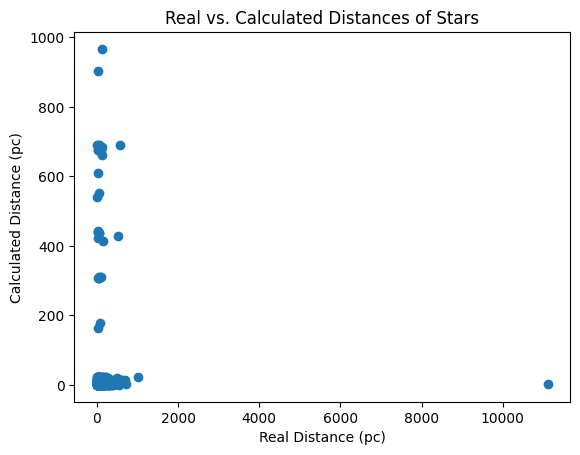

In [29]:
plt.scatter(distances_real, distances)
plt.xlabel('Real Distance (pc)')
plt.ylabel('Calculated Distance (pc)')
plt.title('Real vs. Calculated Distances of Stars')
# plt.xlim(0, 1000)

In [30]:
from sklearn.metrics import root_mean_squared_error
RMSE = root_mean_squared_error(distances_real, distances)
print(RMSE / (max(distances_real) - min(distances_real)))

RMSPE = (np.sqrt(np.mean(np.square((distances_real - distances) / distances_real), axis=0))) * 100
print(RMSPE)

print(np.mean(np.log(distances_real) - np.log(np.array(distances))))

# RMSPE = (np.sqrt(np.mean(np.square((np.log(distances_real) - np.log(np.array(distances))) / np.log(distances_real))))) * 100
# print(RMSPE)

0.051226611367907925
437.7294124903429
2.324129690661887
